# Stock Market Predicton using Numerical and Textual Analysis


## Define Problem

    Stock Market Predictions based on Stock data of Dow Jones and the news headlines for the past 20 years. Stock 
    prices of companies usually has a high impact depending on the things happening around the country. The idea is to use a company’s stock prices and the corresponding news headlines for 15 years and build a model which 
    predicts the stock prices.

## Numerical Data Analysis

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense , LSTM  , Dropout 
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

In [2]:
# We will analyze the last 15 years stock price data of IWM
df = pd.read_csv('IWM.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,65.095001,65.209999,63.570000,63.910000,50.853107,16062600
1,2005-01-04,64.035004,64.084999,62.430000,62.540001,49.762993,27450000
2,2005-01-05,62.470001,62.639999,61.290001,61.290001,48.768360,29884200
3,2005-01-06,61.669998,62.200001,61.224998,61.615002,49.026966,23061200
4,2005-01-07,61.755001,61.950001,60.895000,60.930000,48.481922,20906200


In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4022,2020-12-23,198.570007,199.649994,197.899994,199.139999,197.269363,18392000
4023,2020-12-24,199.929993,199.940002,198.059998,199.009995,197.140594,8904900
4024,2020-12-28,201.160004,201.179993,198.130005,198.270004,196.407562,27168400
4025,2020-12-29,198.639999,199.000000,193.440002,194.429993,192.603607,33901300
4026,2020-12-30,195.050003,197.479996,195.029999,196.410004,194.565018,20595700


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4027 entries, 0 to 4026
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4027 non-null   object 
 1   Open       4027 non-null   float64
 2   High       4027 non-null   float64
 3   Low        4027 non-null   float64
 4   Close      4027 non-null   float64
 5   Adj Close  4027 non-null   float64
 6   Volume     4027 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 220.4+ KB


In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
# Splitting Data into training & testing
#train_data = df[:'2019'].iloc[:,3:4].values
train_data = df['Close'][:3523].values
test_data = df['Close'][3523:].values

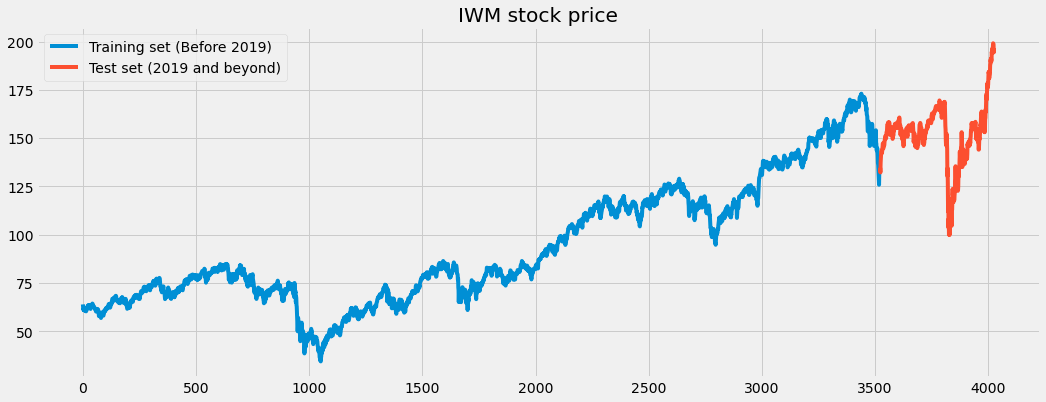

In [7]:
# We have chosen 'Close' attribute for prices
df['Close'][:3523].plot(figsize=(16,6),legend=True)
df['Close'][3523:].plot(figsize=(16,6),legend=True)
plt.legend(['Training set (Before 2019)','Test set (2019 and beyond)'])
plt.title('IWM stock price')
plt.show()

In [8]:
# Scaling the training data
sc = MinMaxScaler()
train_data = train_data.reshape(-1,1)
training_scaler = sc.fit_transform(train_data)
test_data = test_data.reshape(-1,1)
testing_scaler = sc.transform(test_data)

In [9]:
# Since LSTMs store long term memory state, we create a data structure with 30 timesteps and 1 output
# So for each element of training set, we have 30 previous training set elements 
X_train = []
y_train = []
for i in range(30,3523):
    X_train.append(training_scaler[i-30:i,0])
    y_train.append(training_scaler[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [10]:
X_train.shape , y_train.shape

((3493, 30), (3493,))

In [11]:
# Reshaping X_train for modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [12]:
# LSTM Architecture
model = Sequential()
model.add(LSTM(50 , return_sequences=True , input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(50 , return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

In [13]:
earlystopping = EarlyStopping()

In [14]:
# Compiling the LSTM
model.compile(optimizer='rmsprop',loss='mean_squared_error')

In [15]:
# Fitting to the training set
model.fit(X_train,y_train,epochs=50,batch_size=32,validation_split=.1,callbacks=[earlystopping])

Epoch 1/50
99/99 [==============================] - 7s 35ms/step - loss: 0.0100 - val_loss: 0.0064


In [16]:
# 'Close' attribute data for processing
dataset_total = pd.concat((df["Close"][:3523],df["Close"][3523:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_data) - 30:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [17]:
# Preparing X_test
X_test = []
for i in range(30,len(inputs)):
    X_test.append(inputs[i-30:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [18]:
# Predicting the prices
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [19]:
rmse = np.sqrt(mean_squared_error(test_data , predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 12.045090418633537.


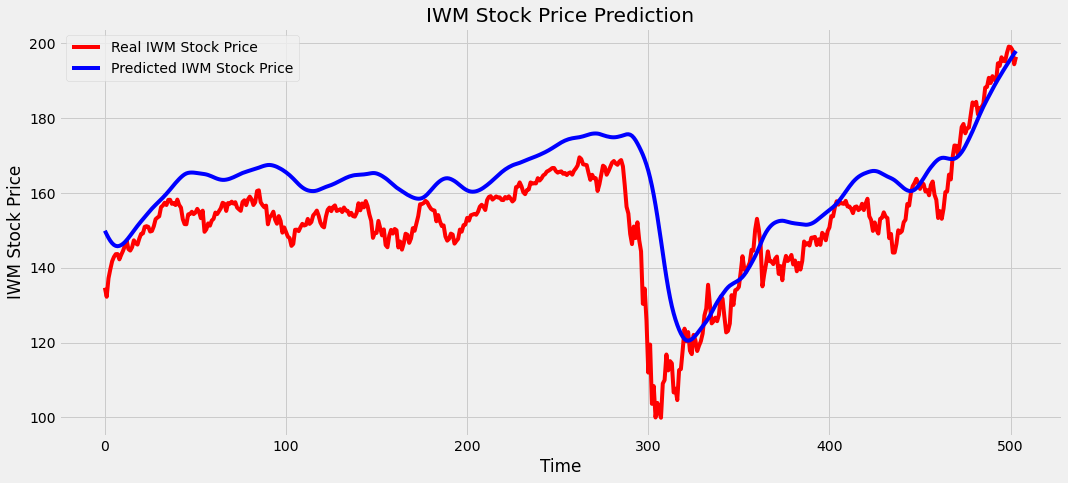

In [20]:
plt.figure(figsize=(16,7))
plt.plot(test_data, color='red',label='Real IWM Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted IWM Stock Price')
plt.title('IWM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IWM Stock Price')
plt.legend()
plt.show()

-----------------------------------------------------

## Text Data Analysis

In [21]:
import re
from textblob import TextBlob
from nltk import word_tokenize , sent_tokenize


In [22]:
df_text = pd.read_csv('india-news-headlines.csv')
df_text.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [23]:
df_text['publish_date'] = pd.to_datetime(df_text['publish_date'],format='%Y%m%d')

    Since, we only have the the numeric data between 2005-01-03 to 2020-12-30, we will only use the text data 
    generated during these dates.

In [24]:
text = df_text[df_text['publish_date'] >= '2005-01-03'].reset_index(drop=True)
text.shape

(3085222, 3)

In [25]:
text['headline_category'].unique()

array(['home.education', 'india', 'unknown', 'city.delhi', 'city.patna',
       'city.lucknow', 'world.rest-of-world', 'city.pune', 'city.kolkata',
       'business.india-business', 'city.thiruvananthapuram',
       'city.mumbai', 'city.bengaluru', 'world.us', 'city.ahmedabad',
       'city.hyderabad', 'entertainment.hindi.bollywood',
       'entertainment.english.hollywood', 'city',
       'sports.icc-world-cup-2015', 'business.international-business',
       'city.chandigarh', 'home.science', 'world.pakistan', 'mumbai',
       'delhi', 'pune', 'hyderabad', 'home.sunday-times.deep-focus',
       'cricket', 'home.sunday-times.all-that-matters', 'removed',
       'calcutta-times', 'delhi-times', 'bangalore-times', 'pune-times',
       'ahmedabad-times', 'lucknow-times', 'bangalore', 'baroda',
       'bombay-times', 'talk-radio', 'hyderabad-times',
       'bachi-karkaria.erratica', 'sa-aiyar.swaminomics',
       'gurcharan-das.men-ideas', 'jug-suraiya.jugular-vein', 'edit-page',
       '

    Since, we are doing a stock price prediction, we only need data related to business

In [26]:
business = [x for x in text['headline_category'].value_counts().index if 'business' in x]
business

['business.india-business',
 'business.international-business',
 'business.personal-finance',
 'business',
 'india-business-news-wire',
 'business.faqs.income-tax-faqs',
 'business.mf-simplified.mf-news',
 'business.mf-simplified.jargon-busters.debt',
 'business.faqs.aadhar-faqs',
 'business.mf-simplified.jargon-busters.equity',
 'business.faqs.gst-faqs',
 'business.mf-simplified.faq']

In [27]:
text = text.loc[text['headline_category'].str.find('business') !=-1].reset_index(drop=True)
text.head()

,publish_date,headline_category,headline_text
0,2005-01-03,business.india-business,Anil Ambani resigns from IPCL
1,2005-01-03,business.india-business,Idea tapping the rural potential
2,2005-01-03,business.india-business,Sensex closes at new high of 6;679
3,2005-01-03,business.india-business,Separate prescriptions for private; public firms
4,2005-01-03,business.india-business,Tsunami not to hit growth: World Bank


    Joining the rows of the same date

In [28]:
text = text.groupby('publish_date').agg({'headline_category':'first','headline_text': '. '.join}).reset_index()
text.head()

,publish_date,headline_category,headline_text
0,2005-01-03,business.india-business,Anil Ambani resigns from IPCL. Idea tapping th...
1,2005-01-04,business.india-business,Sensex will breach 7000-level in 2005. Major c...
2,2005-01-05,business.india-business,Aiyar for an end to 1-year oil contracts. Indi...
3,2005-01-06,business.india-business,ADC slashed; cell tariffs to fall. Govt's help...
4,2005-01-07,business.india-business,Ambanis headed for split: Report. Dividing Rel...


    The BSE SENSEX is a free-float market-weighted stock market index of 30 well-established and financially
    sound companies listed on the Bombay Stock Exchange. The 30 constituent companies which are some of the largest and most actively traded stocks, are representative of various industrial sectors of the Indian economy

In [29]:
text['headline_text'] = text['headline_text'].str.lower()

BSE_count = 0
for txt in text['headline_text']:
    if 'bse' in txt or 'sensex' in txt :
        BSE_count+=1

BSE_count

3465

    Sensex or BSE occurs 3396 times in the whole dataset

In [30]:
def actual_news(data):
    for index in data.index:
        sentences = sent_tokenize(data['headline_text'][index])
        relevant_line = ' '.join(sent for sent in sentences if 'sensex' in sent or 'bse' in sent)
        if len(relevant_line)>5:
            data['headline_text'][index] =relevant_line
    return data

text = actual_news(text)

In [31]:
# Cleaning the text
def clean_txt(text):
    # Removing non alphanumeric text
    text = re.sub('[^a-zA-Z]',' ',text)
    return text

text['headline_text'] = text['headline_text'].apply(clean_txt)

    Sentiment Analysis of News Headlines

In [32]:
def sentiment_analysis(data):
    
    # Create a function to get the Subjectivity
    def getSubjectivity(text):
        return TextBlob(text).sentiment.subjectivity
  
    # Create a function to get the polarity
    def getPolarity(text):
        return TextBlob(text).sentiment.polarity
  
    # Create two new columns 'Subjectivity' & 'Polarity'
    data["Subjectivity"] =    data["headline_text"].apply(getSubjectivity)
    data["Polarity"] =   data["headline_text"].apply(getPolarity)
    
    def getAnalysis(score):
        if score < 0:
            return "Negative"
        elif score == 0:
            return "Neutral"
        else:
            return "Positive"
        
    data["result"] = data["Polarity"].apply(getAnalysis )
    
    return data

In [33]:
df_txt = sentiment_analysis(text)
df_txt

,publish_date,headline_category,headline_text,Subjectivity,Polarity,result
0,2005-01-03,business.india-business,sensex closes at new high of separate p...,0.359053,0.074091,Positive
1,2005-01-04,business.india-business,sensex will breach level in major c...,0.700000,0.431250,Positive
2,2005-01-05,business.india-business,low support from fii led to sensex crash,0.300000,0.000000,Neutral
3,2005-01-06,business.india-business,adc slashed cell tariffs to fall govt s help...,0.000000,0.000000,Neutral
4,2005-01-07,business.india-business,may sensex crash fm for revealing names s...,0.000000,0.000000,Neutral
...,...,...,...,...,...,...
5768,2020-12-27,business.india-business,india to become rd largest economy by r...,0.000000,0.000000,Neutral
5769,2020-12-28,business.india-business,some tyre categories posted record sales shif...,0.386777,0.157851,Positive
5770,2020-12-29,business.india-business,sensex ends above k pts for st time,0.100000,0.000000,Neutral
5771,2020-12-30,business.india-business,finance it stocks take sensex to record levels,0.000000,0.000000,Neutral


In [34]:
sentiment_res = df_txt.groupby(['result']).agg({'headline_text':'count'})
sentiment_res

,headline_text
result,
Negative,1680
Neutral,1339
Positive,2754


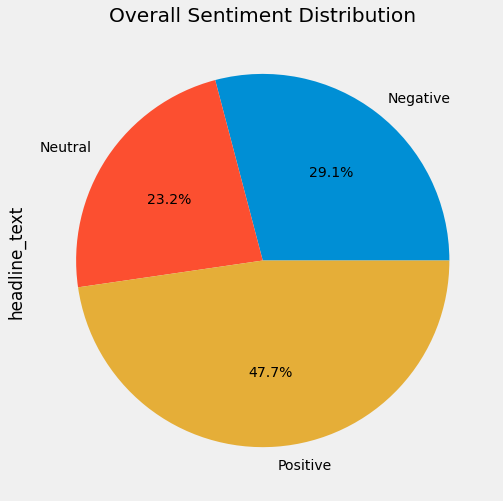

In [35]:
plt.figure(figsize=(8,8))
sentiment_res['headline_text'].plot.pie(autopct='%1.1f%%')
plt.title("Overall Sentiment Distribution")
plt.show()

    Building the Hybrid Model

In [36]:
data = pd.merge(left=df,right=df_txt,
                       left_on=df['Date'],
                       right_on=df_txt['publish_date'],
                       how='outer')

In [37]:
data.head()

,key_0,Date,Open,High,Low,Close,Adj Close,Volume,publish_date,headline_category,headline_text,Subjectivity,Polarity,result
0,2005-01-03,2005-01-03,65.095001,65.209999,63.570000,63.910000,50.853107,16062600.0,2005-01-03,business.india-business,sensex closes at new high of separate p...,0.359053,0.074091,Positive
1,2005-01-04,2005-01-04,64.035004,64.084999,62.430000,62.540001,49.762993,27450000.0,2005-01-04,business.india-business,sensex will breach level in major c...,0.700000,0.431250,Positive
2,2005-01-05,2005-01-05,62.470001,62.639999,61.290001,61.290001,48.768360,29884200.0,2005-01-05,business.india-business,low support from fii led to sensex crash,0.300000,0.000000,Neutral
3,2005-01-06,2005-01-06,61.669998,62.200001,61.224998,61.615002,49.026966,23061200.0,2005-01-06,business.india-business,adc slashed cell tariffs to fall govt s help...,0.000000,0.000000,Neutral
4,2005-01-07,2005-01-07,61.755001,61.950001,60.895000,60.930000,48.481922,20906200.0,2005-01-07,business.india-business,may sensex crash fm for revealing names s...,0.000000,0.000000,Neutral


In [38]:
new_data = data[['Open','High','Low','result','Close']]

In [39]:
new_data.isna().sum()

Open      1773
High      1773
Low       1773
result      27
Close     1773
dtype: int64

In [40]:
new_data.dropna(inplace=True)

In [41]:
data = pd.get_dummies(new_data,columns=['result'],drop_first=True)

In [42]:
# Splitting Data into training & testing
train_data = data.drop(['Close'],axis=1)
test_data = data['Close']

In [43]:
# Scaling data
sc = MinMaxScaler()
training_sc = sc.fit_transform(train_data)
testing_sc = sc.fit_transform(test_data.values.reshape(-1,1))

In [44]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(training_sc, testing_sc, test_size=0.2, random_state = 0)

In [45]:
print('Training shape :' , x_train.shape , y_train.shape)
print('Testing shape  :' , x_test.shape , y_test.shape)

Training shape : (3200, 5) (3200, 1)
Testing shape  : (800, 5) (800, 1)


In [46]:
x_train = np.reshape(x_train,((x_train.shape[0],x_train.shape[1],1)))
x_test = np.reshape(x_test,((x_test.shape[0],x_test.shape[1],1)))

In [47]:
# LSTM Architecture
model = Sequential()
model.add(LSTM(128 , return_sequences=True , input_shape=(x_train.shape[1],1)))
model.add(LSTM(64 , return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

In [48]:
model.compile(optimizer='rmsprop',loss='mean_squared_error')

In [ ]:
# Fitting to the training set
model.fit(x_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
100/100 [==============================] - 3s 7ms/step - loss: 0.0124
Epoch 2/50
100/100 [==============================] - 1s 9ms/step - loss: 0.0058
Epoch 3/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0043
Epoch 4/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0037
Epoch 5/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0032
Epoch 6/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0028
Epoch 7/50
100/100 [==============================] - 1s 9ms/step - loss: 0.0025
Epoch 8/50
100/100 [==============================] - 1s 9ms/step - loss: 0.0021
Epoch 9/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0021
Epoch 10/50
100/100 [==============================] - 1s 9ms/step - loss: 0.0019
Epoch 11/50
100/100 [==============================] - 1s 9ms/step - loss: 0.0018
Epoch 12/50
100/100 [==============================] - 1s 9ms/step - loss: 0.0016
Epoch 13/50
100/100 [====

In [ ]:
# Predicting the prices
predicted_stock_price = model.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test , predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))